In [12]:
import numpy as np
from scipy.stats import norm
from stochoptim.scengen.scenario_tree import ScenarioTree
from stochoptim.scengen.scenario_process import ScenarioProcess
from stochoptim.scengen.variability_process import VariabilityProcess 
from stochoptim.scengen.figure_of_demerit import FigureOfDemerit 

We illustrate on a Geometric Brownian Motion (GBM) the two ways (forward vs. backward) to build a scenario tree with **optimized scenarios**.

# Define a `ScenarioProcess` instance for the GBM

In [2]:
S_0 = 2 # initial value (at stage 0)
delta_t = 1 # time lag between 2 stages
mu = 0 # drift
sigma = 1 # volatility

The `gbm_recurrence` function below implements the dynamic relation of a GBM:  
* $S_{t} = S_{t-1} \exp[(\mu - \sigma^2/2) \Delta t + \sigma  \epsilon_t\sqrt{\Delta t}], \quad t=1,2,\dots$  

where $\epsilon_t$ is a standard normal random variable $N(0,1)$.

The discretization of $\epsilon_t$ is done by quasi-Monte Carlo (QMC) and is implemented by the `epsilon_sample_qmc` method.

In [3]:
def gbm_recurrence(stage, epsilon, scenario_path):
    if stage == 0:
        return {'S': np.array([S_0])}
    else:
        return {'S': scenario_path[stage-1]['S'] \
                        * np.exp((mu - sigma**2 / 2) * delta_t + sigma * np.sqrt(delta_t) * epsilon)}
    
def epsilon_sample_qmc(n_samples, stage, u=0.5):
    return norm.ppf(np.linspace(0, 1-1/n_samples, n_samples) + u / n_samples).reshape(-1, 1)

scenario_process = ScenarioProcess(gbm_recurrence, epsilon_sample_qmc)

# Define a `VariabilityProcess` instance

A `VariabilityProcess` provides the *variability* of a stochastic problem along the stages and the scenarios. What we call 'variability' is a positive number that indicates how variable the future is given the present scenario. 

Mathematically, a `VariabilityProcess` must implement one of the following two methods:
* the `lookback_fct` method which corresponds to the function $\mathcal{V}_{t}(S_{1}, ..., S_{t})$ that provides the variability at stage $t+1$ given the whole past scenario,
* the `looknow_fct` method which corresponds to the function $\mathcal{\tilde{V}}_{t}(\epsilon_t)$ that provides the variability at stage $t+1$ given the present random perturbation $\epsilon_t$. 

If the `lookback_fct` method is provided, the scenarios can be optimized using the key world argument `optimized='forward'`.  
If the `looknow_fct` method is provided, the scenarios can be optimized using the key world argument `optimized='backward'`.

In [4]:
def lookback_fct(stage, scenario_path):
    return scenario_path[stage]['S'][0]

def looknow_fct(stage, epsilon):
    return np.exp(epsilon[0])

my_variability = VariabilityProcess(lookback_fct, looknow_fct)

# Define a `FigureOfDemerit` instance

In [5]:
def demerit_fct(stage, epsilons, weights):
    return 1 / len(epsilons)

my_demerit = FigureOfDemerit(demerit_fct, my_variability)

# Optimized Assignment of Scenarios to Nodes

### `optimized='forward'`

In [6]:
scen_tree = ScenarioTree.from_recurrence(last_stage=3, init=3, recurrence={1: (2,), 2: (1,2), 3: (1,2,3)})

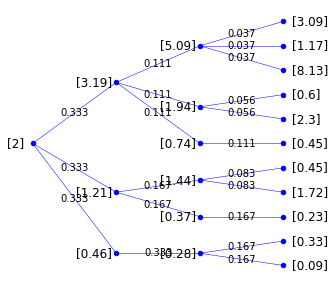

In [7]:
scen_tree.fill(scenario_process, 
               optimized='forward', 
               variability_process=my_variability,
               demerit=my_demerit)
scen_tree.plot('S')

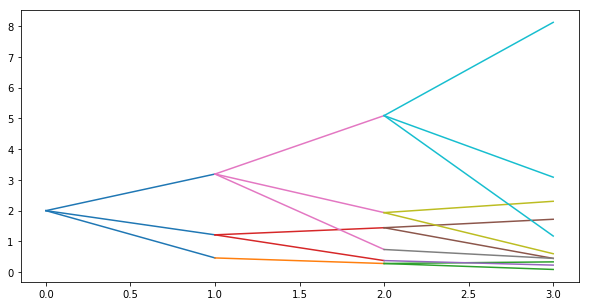

In [8]:
scen_tree.plot_scenarios('S')

### `optimized='backward'`

In [9]:
scen_tree = ScenarioTree.from_recurrence(last_stage=3, init=3, recurrence={1: (2,), 2: (1,2), 3: (1,2,3)})

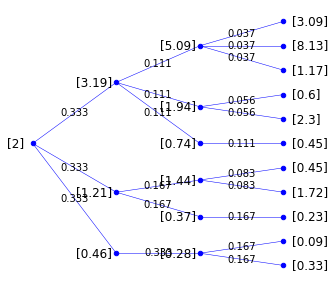

In [10]:
scen_tree.fill(scenario_process, 
               optimized='backward', 
               variability_process=my_variability,
               demerit=my_demerit)
scen_tree.plot('S')

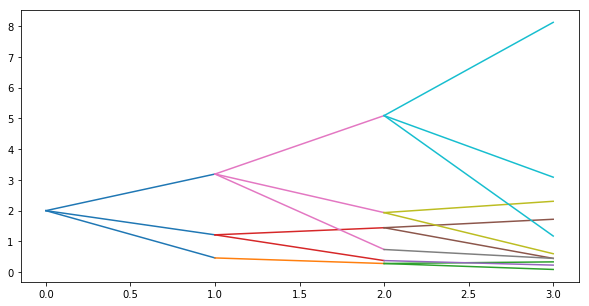

In [11]:
scen_tree.plot_scenarios('S')